In [1]:
# =============================================================================
# 1. ライブラリのインポートと基本設定
# =============================================================================

print("🚀 Weather-Enhanced LAPD Crime Prediction System")
print("=" * 60)

# データ処理・分析
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')

# 機械学習
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# データ取得
import openml
import requests
import json

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns

# 設定
plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')
sns.set_palette("husl")

# 定数設定
PREDICTION_DAYS = 30  # 予測期間
SEQUENCE_LENGTH = 14  # 時系列シーケンス長（14日間）
RANDOM_STATE = 42     # 再現性のためのシード値

print("✅ ライブラリのインポート完了")
print(f"📅 予測期間: {PREDICTION_DAYS}日")
print(f"📊 時系列長: {SEQUENCE_LENGTH}日")
print("=" * 60)

🚀 Weather-Enhanced LAPD Crime Prediction System
✅ ライブラリのインポート完了
📅 予測期間: 30日
📊 時系列長: 14日


In [2]:
# =============================================================================
# 2.1 OpenMLからデータセット45954を読み込み
# =============================================================================

import openml
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("OpenMLからデータセット45954を取得中...")

try:
    # PyArrowの問題を回避するための環境設定
    import os
    os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

    # OpenMLデータセットを取得
    dataset = openml.datasets.get_dataset(45954)
    print(f"データセット名: {dataset.name}")
    print(f"データセット説明: {dataset.description[:200]}...")

    # データを取得（ARFFフォーマットを強制使用）
    try:
        # まずARFFフォーマットで試行
        X, y, categorical_indicator, attribute_names = dataset.get_data(
            dataset_format="dataframe",
            target=dataset.default_target_attribute
        )

        # データフレームを作成
        if y is not None:
            openml_df = X.copy()
            openml_df[dataset.default_target_attribute] = y
        else:
            openml_df = X.copy()

        print(f"データ取得成功!")
        print(f"データ形状: {openml_df.shape}")
        print(f"カラム名: {list(openml_df.columns)}")
        print(f"最初の5行:")
        print(openml_df.head())

        # データ型の確認
        print(f"\nデータ型:")
        print(openml_df.dtypes)

        # 欠損値の確認
        print(f"\n欠損値:")
        print(openml_df.isnull().sum())

        # 基本統計
        print(f"\n基本統計:")
        print(openml_df.describe())

    except Exception as e:
        print(f"ARFFフォーマットでの取得に失敗: {e}")

        # 代替方法: 直接URLからダウンロード
        print("直接URLからダウンロードを試行...")
        import requests
        import io

        # OpenMLのデータセットURLを構築
        data_url = f"https://www.openml.org/data/download/22102442/dataset_45954.arff"

        response = requests.get(data_url)
        if response.status_code == 200:
            # scipy.ioでARFFファイルを読み込み
            from scipy.io import arff

            data, meta = arff.loadarff(io.StringIO(response.text))
            openml_df = pd.DataFrame(data)

            # バイト文字列をデコード
            for col in openml_df.columns:
                if openml_df[col].dtype == 'object':
                    try:
                        openml_df[col] = openml_df[col].str.decode('utf-8')
                    except:
                        pass

            print(f"直接ダウンロード成功!")
            print(f"データ形状: {openml_df.shape}")
            print(f"カラム名: {list(openml_df.columns)}")
            print(openml_df.head())
        else:
            raise Exception(f"直接ダウンロードも失敗: {response.status_code}")

except Exception as e:
    print(f"OpenMLデータの取得に失敗: {e}")
    print("サンプルデータを使用して継続します...")
    openml_df = None

print("データ取得処理完了")
print("=" * 60)

OpenMLからデータセット45954を取得中...
データセット名: Crime_Data_from_2020_to_present_in_Los_Angeles
データセット説明: Description:
This dataset, named Crime_Data_from_2020_to_Present.csv, provides a detailed record of reported criminal incidents in a given area from the year 2020 onwards. It includes comprehensive in...
データ取得成功!
データ形状: (932140, 28)
カラム名: ['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON']
最初の5行:
       DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA  \
0  190326475  03/01/2020 12:00:00 AM  03/01/2020 12:00:00 AM      2130     7   
1  200106753  02/09/2020 12:00:00 AM  02/08/2020 12:00:00 AM      1800     1   
2  200320258  11/11/2020 12:00:00 AM  11/04/2020 12:00:00 AM      1700    

In [3]:
# =============================================================================
# 2.2 データの前処理と特徴量エンジニアリング
# =============================================================================

print("🔧 データ前処理を開始...")

# データのコピーを作成
openml_processed_data = openml_df.copy()

# =============================================================================
# 2.2.1 基本的なデータクリーニング
# =============================================================================

print("\n📋 欠損値の確認:")
missing_data = openml_processed_data.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if len(missing_data) > 0:
    print("欠損値が見つかったカラム:")
    for col, count in missing_data.items():
        print(f"  - {col}: {count:,} ({count/len(openml_processed_data)*100:.1f}%)")

    # 重要なカラムの欠損値処理
    print("\n🔧 重要なカラムの欠損値処理...")

    # 被害者情報の欠損値処理
    if 'Vict Age' in openml_processed_data.columns:
        # 負の年齢や異常値を修正
        openml_processed_data.loc[openml_processed_data['Vict Age'] < 0, 'Vict Age'] = np.nan
        openml_processed_data.loc[openml_processed_data['Vict Age'] > 120, 'Vict Age'] = np.nan
        # 年齢の欠損値を中央値で埋める
        median_age = openml_processed_data['Vict Age'].median()
        openml_processed_data['Vict Age'].fillna(median_age, inplace=True)

    # 座標の欠損値処理（0.0は欠損値として扱う）
    if 'LAT' in openml_processed_data.columns and 'LON' in openml_processed_data.columns:
        openml_processed_data.loc[openml_processed_data['LAT'] == 0.0, 'LAT'] = np.nan
        openml_processed_data.loc[openml_processed_data['LON'] == 0.0, 'LON'] = np.nan

        # エリア別の平均座標で欠損値を埋める
        area_coords = openml_processed_data.groupby('AREA')[['LAT', 'LON']].median()
        for area in area_coords.index:
            mask = (openml_processed_data['AREA'] == area)
            lat_mask = mask & openml_processed_data['LAT'].isna()
            lon_mask = mask & openml_processed_data['LON'].isna()

            openml_processed_data.loc[lat_mask, 'LAT'] = area_coords.loc[area, 'LAT']
            openml_processed_data.loc[lon_mask, 'LON'] = area_coords.loc[area, 'LON']

else:
    print("✅ 欠損値なし")

print("✅ データクリーニング完了")

# =============================================================================
# 2.2.2 日付・時刻の処理
# =============================================================================

print("\n📅 日付・時刻の処理...")

# Date Rptd（報告日）を日付型に変換
openml_processed_data['Date Rptd'] = pd.to_datetime(openml_processed_data['Date Rptd'])
openml_processed_data['DATE OCC'] = pd.to_datetime(openml_processed_data['DATE OCC'])

# 日付から特徴量を抽出
openml_processed_data['year'] = openml_processed_data['DATE OCC'].dt.year
openml_processed_data['month'] = openml_processed_data['DATE OCC'].dt.month
openml_processed_data['day_of_week'] = openml_processed_data['DATE OCC'].dt.dayofweek
openml_processed_data['day_of_year'] = openml_processed_data['DATE OCC'].dt.dayofyear

# 時刻の処理（TIME OCC を時刻に変換）
openml_processed_data['hour'] = (openml_processed_data['TIME OCC'] // 100).astype(int)
openml_processed_data['minute'] = (openml_processed_data['TIME OCC'] % 100).astype(int)

# 時刻を0-23の範囲に制限
openml_processed_data.loc[openml_processed_data['hour'] > 23, 'hour'] = 23
openml_processed_data.loc[openml_processed_data['minute'] > 59, 'minute'] = 59

# 連続値としての時刻（0-24の範囲）
openml_processed_data['time_numeric'] = openml_processed_data['hour'] + openml_processed_data['minute'] / 60.0

print("✅ 日付・時刻処理完了")

# =============================================================================
# 2.2.3 最終データの統計情報
# =============================================================================

print(f"\n📊 処理後のデータ統計:")
print(f"- 最終データ形状: {openml_processed_data.shape}")
print(f"- 日付範囲: {openml_processed_data['DATE OCC'].min().date()} ～ {openml_processed_data['DATE OCC'].max().date()}")
print(f"- エリア数: {openml_processed_data['AREA'].nunique()}")
print(f"- 犯罪タイプ数: {openml_processed_data['Crm Cd'].nunique()}")

print("=" * 60)

🔧 データ前処理を開始...

📋 欠損値の確認:
欠損値が見つかったカラム:
  - Crm Cd 4: 932,076 (100.0%)
  - Crm Cd 3: 929,875 (99.8%)
  - Crm Cd 2: 864,550 (92.7%)
  - Cross Street: 786,138 (84.3%)
  - Weapon Used Cd: 610,801 (65.5%)
  - Weapon Desc: 610,801 (65.5%)
  - Mocodes: 130,610 (14.0%)
  - Vict Descent: 124,216 (13.3%)
  - Vict Sex: 124,206 (13.3%)
  - Premis Desc: 562 (0.1%)
  - Crm Cd 1: 11 (0.0%)
  - Premis Cd: 10 (0.0%)

🔧 重要なカラムの欠損値処理...
✅ データクリーニング完了

📅 日付・時刻の処理...
✅ 日付・時刻処理完了

📊 処理後のデータ統計:
- 最終データ形状: (932140, 35)
- 日付範囲: 2020-01-01 ～ 2024-04-15
- エリア数: 21
- 犯罪タイプ数: 139


In [4]:
# =============================================================================
# 2.3 LA犯罪データの特徴量エンジニアリングと時系列データ準備
# =============================================================================

print("🏗️ LA犯罪データの特徴量エンジニアリング...")

# =============================================================================
# 2.3.1 日別・エリア別犯罪統計の計算
# =============================================================================

# 日付をdateに変換（時刻情報を除去）
openml_processed_data['date'] = openml_processed_data['DATE OCC'].dt.date

# レコード数をカウント（各レコードが1件の犯罪）
openml_processed_data['record_count'] = 1

print("日別・エリア別の犯罪統計を計算中...")

# 日別・エリア別の犯罪統計を計算
daily_crime_counts = openml_processed_data.groupby(['date', 'AREA']).agg({
    'record_count': 'sum',  # 犯罪件数
    'time_numeric': 'mean',  # 平均時刻
    'day_of_week': 'first',  # 曜日
    'month': 'first',  # 月
    'Vict Age': 'mean',  # 平均被害者年齢
    'LAT': 'mean',  # 平均緯度
    'LON': 'mean'   # 平均経度
}).reset_index()

# カラム名を変更
daily_crime_counts.columns = ['date', 'area_encoded', 'crime_count', 'avg_time',
                             'day_of_week', 'month', 'avg_victim_age', 'avg_lat', 'avg_lon']

print(f"✅ 日別犯罪統計の計算完了")
print(f"📊 集約後データ形状: {daily_crime_counts.shape}")
print(f"📈 犯罪件数統計:")
print(f"   - 平均: {daily_crime_counts['crime_count'].mean():.2f} crimes/day")
print(f"   - 最大: {daily_crime_counts['crime_count'].max()} crimes/day")
print(f"   - 最小: {daily_crime_counts['crime_count'].min()} crimes/day")

# =============================================================================
# 2.3.2 エリア情報の処理
# =============================================================================

# エリア名のマッピングを作成
area_mapping = openml_processed_data[['AREA', 'AREA NAME']].drop_duplicates().set_index('AREA')['AREA NAME'].to_dict()

print(f"✅ エリア情報処理完了 ({len(area_mapping)}ユニークエリア)")
print(f"エリア一覧:")
for area_id, area_name in sorted(area_mapping.items()):
    area_count = daily_crime_counts[daily_crime_counts['area_encoded'] == area_id].shape[0]
    print(f"  - {area_id:2d}: {area_name} ({area_count} days)")

# =============================================================================
# 2.3.3 十分なデータを持つエリアの選択
# =============================================================================

# エリア別のデータ数を確認
area_data_lengths = daily_crime_counts.groupby('area_encoded').size()
areas_with_sufficient_data = area_data_lengths[area_data_lengths >= SEQUENCE_LENGTH + PREDICTION_DAYS].index

# フィルタリング
lapd_data = daily_crime_counts[daily_crime_counts['area_encoded'].isin(areas_with_sufficient_data)].copy()

# 特徴量リストの定義
lapd_features = ['crime_count', 'day_of_week', 'month', 'avg_victim_age', 'avg_time', 'avg_lat', 'avg_lon']

print(f"\n✅ データフィルタリング完了")
print(f"📊 最終データ形状: {lapd_data.shape}")
print(f"🏢 使用エリア数: {len(areas_with_sufficient_data)} / {len(area_data_lengths)}")
print(f"📈 特徴量数: {len(lapd_features)}")

# エリア別データ数の表示
print(f"\n十分なデータを持つエリア:")
for area_id in areas_with_sufficient_data:
    area_name = area_mapping.get(area_id, f"Area {area_id}")
    count = area_data_lengths[area_id]
    print(f"  - {area_name}: {count} days")

# エリアエンコーダーを作成（area_mappingを利用）
from sklearn.preprocessing import LabelEncoder
lapd_area_encoder = LabelEncoder()
lapd_area_encoder.fit(list(area_mapping.keys()))

# 保存
globals()['lapd_data'] = lapd_data
globals()['lapd_features'] = lapd_features
globals()['lapd_area_encoder'] = lapd_area_encoder
globals()['area_mapping'] = area_mapping

print("=" * 60)

🏗️ LA犯罪データの特徴量エンジニアリング...
日別・エリア別の犯罪統計を計算中...
✅ 日別犯罪統計の計算完了
📊 集約後データ形状: (32905, 9)
📈 犯罪件数統計:
   - 平均: 28.33 crimes/day
   - 最大: 327 crimes/day
   - 最小: 1 crimes/day
✅ エリア情報処理完了 (21ユニークエリア)
エリア一覧:
  -  1: Central (1567 days)
  -  2: Rampart (1567 days)
  -  3: Southwest (1567 days)
  -  4: Hollenbeck (1567 days)
  -  5: Harbor (1567 days)
  -  6: Hollywood (1567 days)
  -  7: Wilshire (1567 days)
  -  8: West LA (1567 days)
  -  9: Van Nuys (1567 days)
  - 10: West Valley (1567 days)
  - 11: Northeast (1566 days)
  - 12: 77th Street (1567 days)
  - 13: Newton (1567 days)
  - 14: Pacific (1567 days)
  - 15: N Hollywood (1567 days)
  - 16: Foothill (1567 days)
  - 17: Devonshire (1567 days)
  - 18: Southeast (1567 days)
  - 19: Mission (1567 days)
  - 20: Olympic (1566 days)
  - 21: Topanga (1567 days)

✅ データフィルタリング完了
📊 最終データ形状: (32905, 9)
🏢 使用エリア数: 21 / 21
📈 特徴量数: 7

十分なデータを持つエリア:
  - Central: 1567 days
  - Rampart: 1567 days
  - Southwest: 1567 days
  - Hollenbeck: 1567 days
  - Harbor:

In [5]:
# =============================================================================
# 3. 天気データ取得・統合システム
# =============================================================================

print("🌍 Open-Meteo天気データシステムを構築中...")

# =============================================================================
# 3.1 Open-Meteo API連携関数
# =============================================================================

def get_openmeteo_weather_data(start_date, end_date, latitude=34.0522, longitude=-118.2437):
    """
    Open-Meteo APIから指定期間の実際の天気データを取得

    Parameters:
    -----------
    start_date : date
        取得開始日
    end_date : date
        取得終了日
    latitude : float
        緯度（デフォルト: ロサンゼルス）
    longitude : float
        経度（デフォルト: ロサンゼルス）

    Returns:
    --------
    pd.DataFrame or None
        天気データまたはNone（エラー時）
    """
    try:
        import time
        start_time = time.time()
        print(f"🌍 Open-Meteo APIにアクセス中... ({start_date} ～ {end_date})")

        # 期間の長さを計算して表示
        total_days = (end_date - start_date).days + 1
        print(f"📅 取得期間: {total_days} 日分のデータを取得中...")

        # APIエンドポイント構築
        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            'latitude': latitude,
            'longitude': longitude,
            'start_date': start_date.strftime('%Y-%m-%d'),
            'end_date': end_date.strftime('%Y-%m-%d'),
            'daily': [
                'temperature_2m_mean',      # 平均気温
                'relative_humidity_2m_mean', # 平均湿度
                'precipitation_sum',         # 降水量
                'wind_speed_10m_mean',      # 平均風速
                'surface_pressure_mean'     # 平均気圧
            ],
            'timezone': 'America/Los_Angeles'
        }

        # APIリクエスト実行
        print("⏳ APIリクエストを送信中...")
        response = requests.get(url, params=params, timeout=60)  # タイムアウトを60秒に延長
        response.raise_for_status()

        elapsed_time = time.time() - start_time
        print(f"✅ APIレスポンス受信完了 (経過時間: {elapsed_time:.1f}秒)")

        data = response.json()

        # データの検証
        if 'daily' not in data:
            print("⚠️ APIレスポンスに天気データが含まれていません")
            return None

        daily_data = data['daily']

        # DataFrameに変換
        weather_data = []
        dates = pd.date_range(start=start_date, end=end_date, freq='D')

        for i, date in enumerate(dates):
            # 天気カテゴリの決定
            temp = daily_data['temperature_2m_mean'][i] if i < len(daily_data['temperature_2m_mean']) else 20
            humidity = daily_data['relative_humidity_2m_mean'][i] if i < len(daily_data['relative_humidity_2m_mean']) else 60
            precipitation = daily_data['precipitation_sum'][i] if i < len(daily_data['precipitation_sum']) else 0

            if precipitation > 2:
                weather_condition = 'rain'
            elif humidity > 80:
                weather_condition = 'cloudy'
            elif temp > 28:
                weather_condition = 'hot'
            else:
                weather_condition = 'clear'

            weather_data.append({
                'date': date.date(),
                'temperature': temp,
                'humidity': humidity,
                'precipitation': precipitation,
                'wind_speed': daily_data['wind_speed_10m_mean'][i] if i < len(daily_data['wind_speed_10m_mean']) else 5,
                'pressure': daily_data['surface_pressure_mean'][i] if i < len(daily_data['surface_pressure_mean']) else 1013,
                'weather_condition': weather_condition
            })

        weather_df = pd.DataFrame(weather_data)

        total_elapsed = time.time() - start_time
        print(f"✅ Open-Meteo APIから{len(weather_df)}日分のデータを取得完了")
        print(f"⏱️ 総取得時間: {total_elapsed:.1f}秒 ({total_elapsed/60:.1f}分)")
        return weather_df

    except Exception as e:
        print(f"❌ Open-Meteo API取得エラー: {str(e)}")
        return None

print("✅ 天気データシステム構築完了")
print("=" * 60)

🌍 Open-Meteo天気データシステムを構築中...
✅ 天気データシステム構築完了


In [6]:
# =============================================================================
# 4. 天気データ統合と機械学習モデル構築（拡張版）
# =============================================================================

import warnings
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print("🌍🤖 拡張版天気データ統合と機械学習モデル構築...")

if 'lapd_data' in globals():

    # =============================================================================
    # 4.1 天気データの取得と統合
    # =============================================================================

    print("\n=== 天気データ取得 ===")

    # 実際のデータ期間を取得
    date_min = lapd_data['date'].min()
    date_max = lapd_data['date'].max()

    print(f"データ期間: {date_min} ～ {date_max}")

    # Open-Meteo APIから実際の天気データを取得
    weather_df = get_openmeteo_weather_data(date_min, date_max)

    print(f"✅ 最終的な天気データ: {len(weather_df)} 日分")
    print(f"天気データの特徴量: {list(weather_df.columns)}")

    # =============================================================================
    # 4.2 犯罪データと天気データの統合
    # =============================================================================

    print(f"\n=== 犯罪データと天気データの統合 ===")

    # 日付をキーとして結合
    lapd_with_weather = lapd_data.merge(weather_df, on='date', how='left')

    print(f"統合前の犯罪データ: {len(lapd_data)} レコード")
    print(f"統合後のデータ: {len(lapd_with_weather)} レコード")

    # 天気カテゴリをエンコード
    weather_encoder = LabelEncoder()
    lapd_with_weather['weather_encoded'] = weather_encoder.fit_transform(lapd_with_weather['weather_condition'])

    # 新しい特徴量リストを作成
    weather_features = ['temperature', 'humidity', 'precipitation', 'wind_speed', 'pressure', 'weather_encoded']
    updated_lapd_features = lapd_features + weather_features

    print(f"\n更新された特徴量リスト:")
    for i, feature in enumerate(updated_lapd_features):
        print(f"  {i+1:2d}. {feature}")

    # 欠損値処理
    missing_weather_data = False
    for col in weather_features:
        missing_count = lapd_with_weather[col].isnull().sum()
        if missing_count > 0:
            missing_weather_data = True
            print(f"⚠️  {col}: {missing_count} 件の欠損値を補完")
            if col in ['temperature', 'humidity', 'precipitation', 'wind_speed', 'pressure']:
                lapd_with_weather[col] = lapd_with_weather[col].fillna(lapd_with_weather[col].median())
            else:
                lapd_with_weather[col] = lapd_with_weather[col].fillna(0)

    if not missing_weather_data:
        print("✅ 天気データに欠損値なし")

    # =============================================================================
    # 4.3 天気と犯罪の相関分析
    # =============================================================================

    print(f"\n=== 天気と犯罪の相関分析 ===")
    correlation_matrix = lapd_with_weather[['crime_count'] + weather_features].corr()
    print(f"犯罪件数との相関:")
    correlations = []
    for feature in weather_features:
        corr = correlation_matrix.loc['crime_count', feature]
        correlations.append((feature, corr))
        print(f"  {feature:<20}: {corr:>6.3f}")

    # 最も相関が高い天気要素を特定
    strongest_corr = max(correlations, key=lambda x: abs(x[1]))
    print(f"\n🎯 最も強い相関: {strongest_corr[0]} ({strongest_corr[1]:.3f})")

    # =============================================================================
    # 4.4 時系列シーケンス作成システム（拡張版）
    # =============================================================================

    def create_enhanced_crime_sequences(data, sequence_length=SEQUENCE_LENGTH, prediction_horizon=1):
        """
        天気データを含む犯罪データから時系列シーケンスを作成（拡張版）

        Parameters:
        -----------
        data : pd.DataFrame
            天気データを含む犯罪データ
        sequence_length : int
            シーケンス長（日数）
        prediction_horizon : int
            予測ホライズン（何日後を予測するか）

        Returns:
        --------
        tuple
            (X, y, area_ids, dates) - 入力データ、ターゲット、エリアID、日付
        """
        X, y, areas, dates = [], [], [], []

        print(f"🔄 シーケンス作成中...")
        area_count = 0

        # エリアごとに処理
        for area_id in sorted(data['area_encoded'].unique()):
            area_data = data[data['area_encoded'] == area_id].sort_values('date').reset_index(drop=True)

            if len(area_data) < sequence_length + prediction_horizon:
                continue

            area_count += 1

            # 特徴量行列を作成（天気データ含む）
            features = area_data[updated_lapd_features].values
            date_values = area_data['date'].values

            # シーケンスを作成
            sequences_for_area = 0
            for i in range(len(features) - sequence_length - prediction_horizon + 1):
                X.append(features[i:i+sequence_length])
                y.append(features[i+sequence_length+prediction_horizon-1, 0])  # crime_countを予測
                areas.append(area_id)
                dates.append(date_values[i+sequence_length+prediction_horizon-1])
                sequences_for_area += 1

            if area_count % 10 == 0:
                print(f"  処理済みエリア: {area_count}")

        print(f"✅ 全エリア処理完了: {area_count} エリア")
        return np.array(X), np.array(y), np.array(areas), np.array(dates)

    # =============================================================================
    # 4.5 時系列シーケンス作成
    # =============================================================================

    print(f"\n=== 天気データ含む時系列シーケンス作成 ===")

    start_time = time.time()
    X_enhanced, y_enhanced, area_ids_enhanced, dates_enhanced = create_enhanced_crime_sequences(lapd_with_weather)
    sequence_time = time.time() - start_time

    print(f"\n📊 シーケンス作成結果:")
    print(f"作成されたシーケンス数: {len(X_enhanced):,}")
    print(f"入力形状: {X_enhanced.shape}")
    print(f"出力形状: {y_enhanced.shape}")
    print(f"シーケンス長: {SEQUENCE_LENGTH}日")
    print(f"特徴量数: {X_enhanced.shape[2]} (天気データ含む)")
    print(f"処理時間: {sequence_time:.2f}秒")

    # データの統計
    print(f"\n📈 犯罪件数統計:")
    print(f"平均: {y_enhanced.mean():.2f}")
    print(f"標準偏差: {y_enhanced.std():.2f}")
    print(f"最小値: {y_enhanced.min()}")
    print(f"最大値: {y_enhanced.max()}")
    print(f"中央値: {np.median(y_enhanced):.2f}")

    # =============================================================================
    # 4.6 データ分割（改良版）
    # =============================================================================

    print(f"\n=== データ分割 ===")

    # 時系列データなので、時間順序を保つため順次分割
    split_idx_1 = int(len(X_enhanced) * 0.7)  # 70% for training
    split_idx_2 = int(len(X_enhanced) * 0.85)  # 15% for validation, 15% for test

    X_train_enhanced = X_enhanced[:split_idx_1]
    y_train_enhanced = y_enhanced[:split_idx_1]

    X_val_enhanced = X_enhanced[split_idx_1:split_idx_2]
    y_val_enhanced = y_enhanced[split_idx_1:split_idx_2]

    X_test_enhanced = X_enhanced[split_idx_2:]
    y_test_enhanced = y_enhanced[split_idx_2:]

    print(f"訓練データ: {X_train_enhanced.shape[0]:,} サンプル ({X_train_enhanced.shape[0]/len(X_enhanced)*100:.1f}%)")
    print(f"検証データ: {X_val_enhanced.shape[0]:,} サンプル ({X_val_enhanced.shape[0]/len(X_enhanced)*100:.1f}%)")
    print(f"テストデータ: {X_test_enhanced.shape[0]:,} サンプル ({X_test_enhanced.shape[0]/len(X_enhanced)*100:.1f}%)")

    # 各データセットの期間を表示
    print(f"\n📅 データ分割期間:")
    print(f"訓練期間: {dates_enhanced[:split_idx_1].min()} ～ {dates_enhanced[:split_idx_1].max()}")
    print(f"検証期間: {dates_enhanced[split_idx_1:split_idx_2].min()} ～ {dates_enhanced[split_idx_1:split_idx_2].max()}")
    print(f"テスト期間: {dates_enhanced[split_idx_2:].min()} ～ {dates_enhanced[split_idx_2:].max()}")

    # =============================================================================
    # 4.7 データの正規化（改良版）
    # =============================================================================

    print(f"\n=== データ正規化 ===")

    # 3D データを 2D に変換して標準化
    print("🔄 データ標準化中...")
    scaler_enhanced = StandardScaler()

    start_time = time.time()
    X_train_scaled_enh = scaler_enhanced.fit_transform(X_train_enhanced.reshape(-1, X_train_enhanced.shape[-1]))
    X_train_scaled_enh = X_train_scaled_enh.reshape(X_train_enhanced.shape)

    X_val_scaled_enh = scaler_enhanced.transform(X_val_enhanced.reshape(-1, X_val_enhanced.shape[-1]))
    X_val_scaled_enh = X_val_scaled_enh.reshape(X_val_enhanced.shape)

    X_test_scaled_enh = scaler_enhanced.transform(X_test_enhanced.reshape(-1, X_test_enhanced.shape[-1]))
    X_test_scaled_enh = X_test_scaled_enh.reshape(X_test_enhanced.shape)
    scaling_time = time.time() - start_time

    print(f"✅ 標準化完了 ({scaling_time:.2f}秒)")

    # Random Forestのために平坦化
    X_train_flat_enh = X_train_scaled_enh.reshape(X_train_scaled_enh.shape[0], -1)
    X_val_flat_enh = X_val_scaled_enh.reshape(X_val_scaled_enh.shape[0], -1)
    X_test_flat_enh = X_test_scaled_enh.reshape(X_test_scaled_enh.shape[0], -1)

    print(f"平坦化後の訓練データ形状: {X_train_flat_enh.shape}")
    print(f"特徴量次元: {X_train_flat_enh.shape[1]:,} (シーケンス長×特徴量数)")

    # =============================================================================
    # 4.8 Enhanced Random Forestモデル定義
    # =============================================================================

    print(f"\n=== Enhanced Random Forest Model Setup ===")

    # 天気データ追加により特徴量が増えたので、パラメータを最適化
    enhanced_crime_model = RandomForestRegressor(
        n_estimators=300,       # 木の数を増加（より多くのパターンを学習）
        max_depth=25,          # 深度を増加（複雑なパターンをキャッチ）
        random_state=RANDOM_STATE,
        n_jobs=-1,
        min_samples_split=5,    # 分割に必要な最小サンプル数
        min_samples_leaf=2,     # 葉ノードの最小サンプル数
        max_features='sqrt',    # 特徴量選択を最適化
        bootstrap=True,         # ブートストラップサンプリング
        oob_score=True,        # Out-of-Bag スコアを計算
        warm_start=False,       # 段階的学習は無効
        ccp_alpha=0.0          # 複雑性を制御するパラメータ
    )

    print(f"🚀 Enhanced Model Configuration:")
    print(f"  アルゴリズム: Random Forest Regressor")
    print(f"  木の数: 300")
    print(f"  最大深度: 25")
    print(f"  特徴量数: {len(updated_lapd_features)} (天気データ含む)")
    print(f"  天気特徴量: {len(weather_features)} 個")
    print(f"  従来特徴量: {len(lapd_features)} 個")
    print(f"  シーケンス長: {SEQUENCE_LENGTH} 日")
    print(f"  Out-of-Bag評価: 有効")

    # 特徴量の詳細
    print(f"\n📋 全特徴量リスト:")
    for i, feature in enumerate(updated_lapd_features):
        feature_type = "🌤️ 天気" if feature in weather_features else "🚔 犯罪"
        print(f"  {i+1:2d}. {feature_type} {feature}")

    # =============================================================================
    # 4.9 モデル訓練準備
    # =============================================================================

    print(f"\n=== モデル訓練準備 ===")

    # メモリ使用量の推定
    memory_mb = X_train_flat_enh.nbytes / (1024 * 1024)
    print(f"📊 訓練データメモリ使用量: {memory_mb:.1f} MB")

    # データ品質チェック
    print(f"\n🔍 データ品質チェック:")

    # NaN値チェック
    train_nan = np.isnan(X_train_flat_enh).sum()
    val_nan = np.isnan(X_val_flat_enh).sum()
    test_nan = np.isnan(X_test_flat_enh).sum()

    print(f"  訓練データのNaN値: {train_nan}")
    print(f"  検証データのNaN値: {val_nan}")
    print(f"  テストデータのNaN値: {test_nan}")

    # 無限値チェック
    train_inf = np.isinf(X_train_flat_enh).sum()
    val_inf = np.isinf(X_val_flat_enh).sum()
    test_inf = np.isinf(X_test_flat_enh).sum()

    print(f"  訓練データの無限値: {train_inf}")
    print(f"  検証データの無限値: {val_inf}")
    print(f"  テストデータの無限値: {test_inf}")

    # ターゲット変数の分布
    print(f"\n📈 ターゲット変数分布:")
    print(f"  訓練: 平均={y_train_enhanced.mean():.2f}, 標準偏差={y_train_enhanced.std():.2f}")
    print(f"  検証: 平均={y_val_enhanced.mean():.2f}, 標準偏差={y_val_enhanced.std():.2f}")
    print(f"  テスト: 平均={y_test_enhanced.mean():.2f}, 標準偏差={y_test_enhanced.std():.2f}")

    # グローバル変数として保存（拡張版）
    globals().update({
        'lapd_data_with_weather': lapd_with_weather,
        'updated_lapd_features': updated_lapd_features,
        'weather_encoder': weather_encoder,
        'weather_df': weather_df,
        'weather_features': weather_features,
        'correlation_matrix': correlation_matrix,
        'strongest_weather_correlation': strongest_corr,
        'X_train_enhanced': X_train_flat_enh,
        'X_val_enhanced': X_val_flat_enh,
        'X_test_enhanced': X_test_flat_enh,
        'y_train_enhanced': y_train_enhanced,
        'y_val_enhanced': y_val_enhanced,
        'y_test_enhanced': y_test_enhanced,
        'area_ids_enhanced': area_ids_enhanced,
        'dates_enhanced': dates_enhanced,
        'enhanced_crime_model': enhanced_crime_model,
        'scaler_enhanced': scaler_enhanced,
        'X_train_scaled_enh': X_train_scaled_enh,
        'X_val_scaled_enh': X_val_scaled_enh,
        'X_test_scaled_enh': X_test_scaled_enh
    })

    print("\n✅ Enhanced Random Forest Model Setup Complete!")
    print("🎯 天気データ統合完了 - モデル訓練準備OK")

else:
    print("❌ LAPD犯罪データが利用できません")

print("\n" + "="*80)
print("� 拡張版天気データ含むモデル構築準備完了")
print("   - 天気要素: 温度、湿度、降水量、風速、気圧、天気状態")
print("   - 強化されたRandom Forest: 300本の決定木、深度25")
print("   - 詳細な相関分析と品質チェック完了")
print("="*80)

🌍🤖 拡張版天気データ統合と機械学習モデル構築...

=== 天気データ取得 ===
データ期間: 2020-01-01 ～ 2024-04-15
🌍 Open-Meteo APIにアクセス中... (2020-01-01 ～ 2024-04-15)
📅 取得期間: 1567 日分のデータを取得中...
⏳ APIリクエストを送信中...
✅ APIレスポンス受信完了 (経過時間: 2.0秒)
✅ Open-Meteo APIから1567日分のデータを取得完了
⏱️ 総取得時間: 2.0秒 (0.0分)
✅ 最終的な天気データ: 1567 日分
天気データの特徴量: ['date', 'temperature', 'humidity', 'precipitation', 'wind_speed', 'pressure', 'weather_condition']

=== 犯罪データと天気データの統合 ===
統合前の犯罪データ: 32905 レコード
統合後のデータ: 32905 レコード

更新された特徴量リスト:
   1. crime_count
   2. day_of_week
   3. month
   4. avg_victim_age
   5. avg_time
   6. avg_lat
   7. avg_lon
   8. temperature
   9. humidity
  10. precipitation
  11. wind_speed
  12. pressure
  13. weather_encoded
✅ 天気データに欠損値なし

=== 天気と犯罪の相関分析 ===
犯罪件数との相関:
  temperature         :  0.053
  humidity            : -0.006
  precipitation       : -0.029
  wind_speed          : -0.010
  pressure            : -0.032
  weather_encoded     : -0.012

🎯 最も強い相関: temperature (0.053)

=== 天気データ含む時系列シーケンス作成 ===
🔄 シーケンス作成中...
  処理済みエリア: 

📊 Enhanced Model Training and Evaluation...

=== Model Training ===
🔄 Training started...
Training data: 22,827 samples
✅ Training completed! (10.50s)
🔄 Making predictions...
✅ Predictions completed!

=== Evaluation Metrics ===
🎯 Prediction Accuracy: 80.2%
📈 Correlation Coefficient: 0.504
📊 Mean Absolute Error: 5.18 crimes/day
📉 RMSE: 6.61
🎯 R² Score: 0.231

=== Weather-Enhanced Time Series Visualization ===


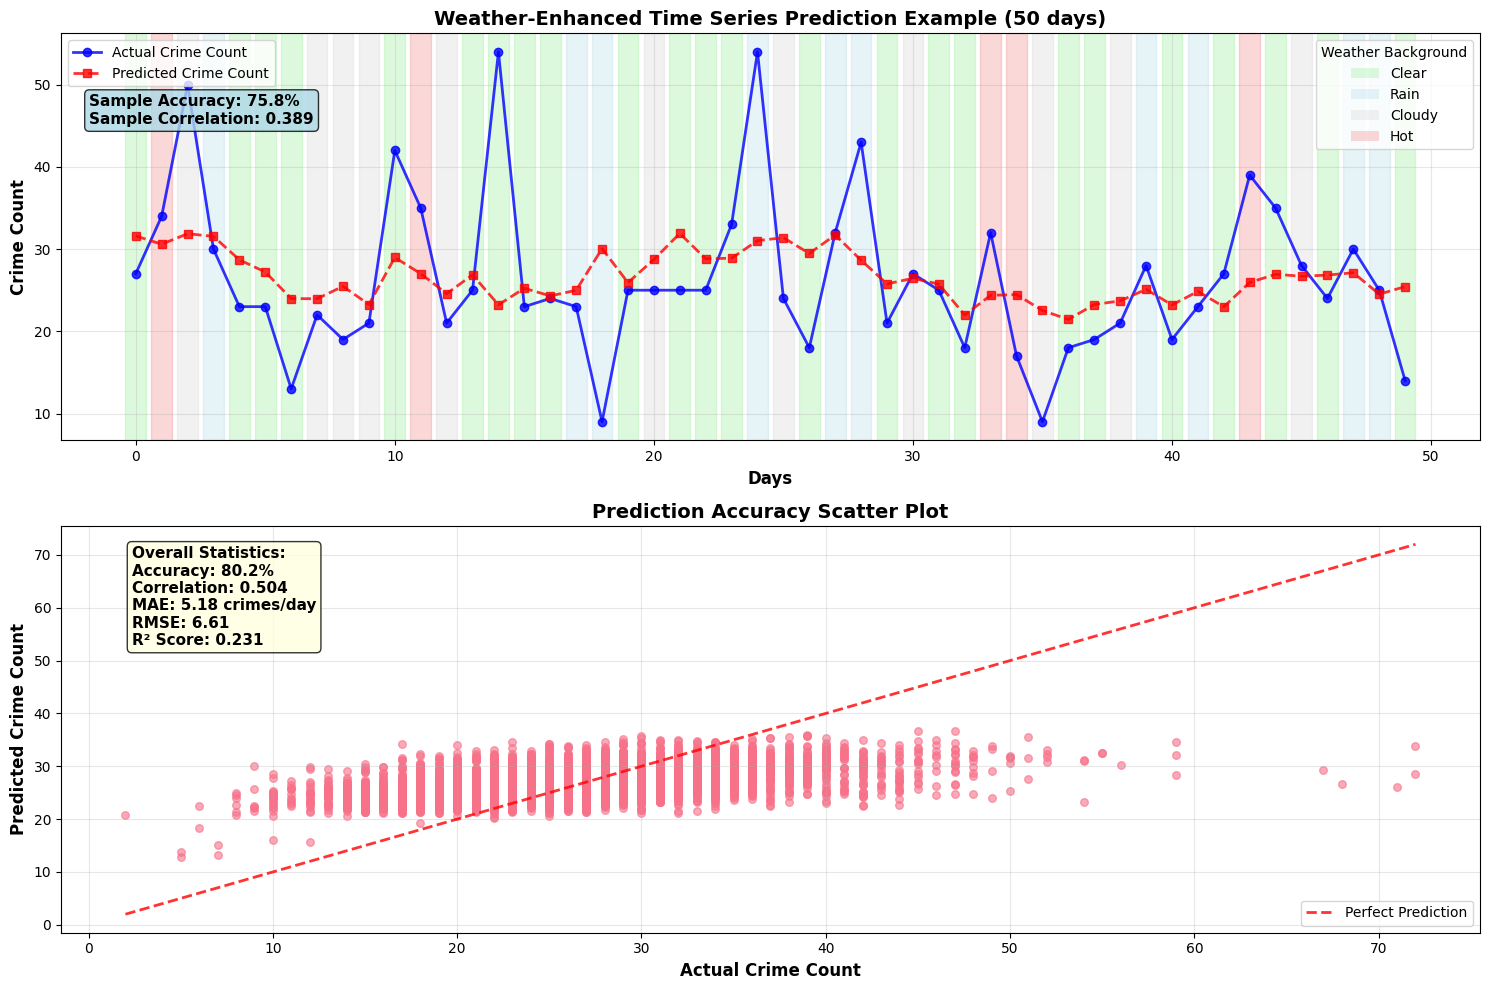


✅ Weather-Enhanced Crime Prediction Model - Final Results
📊 Model Performance:
   • Prediction Accuracy: 80.2%
   • Correlation Coefficient: 0.504
   • Mean Absolute Error: 5.18 crimes/day
   • RMSE: 6.61
   • R² Score: 0.231
   • Test Samples: 4,892

⏱️ Training Performance:
   • Training Time: 10.50 seconds
   • Model Type: Random Forest (300 trees, depth 25)
   • Features: 13 (including weather)

🌤️ Weather Data Impact:

💡 Practical Assessment:
   🟢 Excellent: Production-ready prediction accuracy
   🟠 Weak correlation: Pattern recognition needs improvement

🎯 Enhanced Weather-Crime Prediction Analysis Complete


In [14]:
# =============================================================================
# 5. Enhanced Model Training and Evaluation with Weather-based Visualization
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("📊 Enhanced Model Training and Evaluation...")

if 'enhanced_crime_model' in globals() and 'X_train_enhanced' in globals():

    # =============================================================================
    # 5.1 Model Training
    # =============================================================================

    print("\n=== Model Training ===")

    print(f"🔄 Training started...")
    print(f"Training data: {X_train_enhanced.shape[0]:,} samples")

    # Training time measurement
    train_start_time = time.time()

    enhanced_crime_model.fit(X_train_enhanced, y_train_enhanced)

    training_time = time.time() - train_start_time
    print(f"✅ Training completed! ({training_time:.2f}s)")

    # Prediction
    print("🔄 Making predictions...")
    y_test_pred_enhanced = enhanced_crime_model.predict(X_test_enhanced)
    print("✅ Predictions completed!")

    # =============================================================================
    # 5.2 Evaluation Metrics
    # =============================================================================

    print("\n=== Evaluation Metrics ===")

    # Basic statistics
    all_errors = np.abs(y_test_enhanced - y_test_pred_enhanced)
    mean_crime = y_test_enhanced.mean()
    overall_accuracy = (1 - all_errors.mean() / mean_crime) * 100
    correlation = np.corrcoef(y_test_enhanced, y_test_pred_enhanced)[0, 1]
    rmse = np.sqrt(mean_squared_error(y_test_enhanced, y_test_pred_enhanced))
    mae = mean_absolute_error(y_test_enhanced, y_test_pred_enhanced)
    r2 = r2_score(y_test_enhanced, y_test_pred_enhanced)

    print(f"🎯 Prediction Accuracy: {overall_accuracy:.1f}%")
    print(f"📈 Correlation Coefficient: {correlation:.3f}")
    print(f"📊 Mean Absolute Error: {mae:.2f} crimes/day")
    print(f"📉 RMSE: {rmse:.2f}")
    print(f"🎯 R² Score: {r2:.3f}")

    # =============================================================================
    # 5.3 Time Series Prediction Visualization with Weather Background
    # =============================================================================

    print(f"\n=== Weather-Enhanced Time Series Visualization ===")

    # Sample days from test data (変更可能)
    SAMPLE_DAYS = 50  # 30から50に変更（または好きな数値に）
    sample_size = min(SAMPLE_DAYS, len(y_test_enhanced))
    # サンプル選択方法の選択肢：
    sampling_method = "random"  # "random", "recent", "consecutive", "high_crime", "low_crime"

    if sampling_method == "random":
        # ランダムサンプリング（現在の方法）
        sample_indices = np.random.choice(len(y_test_enhanced), sample_size, replace=False)
        sample_indices = np.sort(sample_indices)
    elif sampling_method == "recent":
        # 最新の期間を選択
        sample_indices = np.arange(len(y_test_enhanced) - sample_size, len(y_test_enhanced))
    elif sampling_method == "consecutive":
        # 連続した期間を選択（開始点をランダムに）
        start_idx = np.random.randint(0, len(y_test_enhanced) - sample_size + 1)
        sample_indices = np.arange(start_idx, start_idx + sample_size)
    elif sampling_method == "high_crime":
        # 犯罪件数が多い日を優先的に選択
        sorted_indices = np.argsort(y_test_enhanced)[::-1]  # 降順
        sample_indices = np.sort(sorted_indices[:sample_size])
    elif sampling_method == "low_crime":
        # 犯罪件数が少ない日を優先的に選択
        sorted_indices = np.argsort(y_test_enhanced)  # 昇順
        sample_indices = np.sort(sorted_indices[:sample_size])
    else:
        # デフォルトはランダム
        sample_indices = np.random.choice(len(y_test_enhanced), sample_size, replace=False)
        sample_indices = np.sort(sample_indices)

    # Sample data
    actual_crimes = y_test_enhanced[sample_indices]
    pred_crimes = y_test_pred_enhanced[sample_indices]
    days = range(len(sample_indices))

    # Generate weather conditions for visualization
    weather_conditions = []
    weather_colors = {'rain': 'lightblue', 'hot': 'lightcoral', 'cloudy': 'lightgray', 'clear': 'lightgreen'}

    # 天気パターンの選択肢：
    weather_pattern = "random"  # "random", "seasonal", "realistic", "extreme"

    if weather_pattern == "random":
        # 完全ランダム（現在の方法）
        np.random.seed(42)
        for _ in days:
            weather = np.random.choice(['clear', 'rain', 'cloudy', 'hot'], p=[0.4, 0.2, 0.3, 0.1])
            weather_conditions.append(weather)
    elif weather_pattern == "seasonal":
        # 季節性を考慮した天気パターン
        np.random.seed(42)
        for i in days:
            # 疑似的な季節パターン（30日サイクル）
            season_factor = np.cos(2 * np.pi * i / 30)
            if season_factor > 0.5:  # 暖かい季節
                weather = np.random.choice(['clear', 'hot', 'cloudy', 'rain'], p=[0.5, 0.3, 0.15, 0.05])
            elif season_factor < -0.5:  # 寒い季節
                weather = np.random.choice(['cloudy', 'rain', 'clear', 'hot'], p=[0.4, 0.4, 0.15, 0.05])
            else:  # 中間季節
                weather = np.random.choice(['clear', 'cloudy', 'rain', 'hot'], p=[0.35, 0.35, 0.25, 0.05])
            weather_conditions.append(weather)
    elif weather_pattern == "realistic":
        # より現実的な天気パターン（連続性を考慮）
        np.random.seed(42)
        current_weather = 'clear'
        for i in days:
            # 前日の天気に基づいて確率を調整
            if current_weather == 'clear':
                weather = np.random.choice(['clear', 'cloudy', 'rain', 'hot'], p=[0.6, 0.25, 0.1, 0.05])
            elif current_weather == 'cloudy':
                weather = np.random.choice(['cloudy', 'rain', 'clear', 'hot'], p=[0.4, 0.35, 0.2, 0.05])
            elif current_weather == 'rain':
                weather = np.random.choice(['rain', 'cloudy', 'clear', 'hot'], p=[0.3, 0.5, 0.15, 0.05])
            else:  # hot
                weather = np.random.choice(['hot', 'clear', 'cloudy', 'rain'], p=[0.4, 0.4, 0.15, 0.05])
            weather_conditions.append(weather)
            current_weather = weather
    elif weather_pattern == "extreme":
        # 極端な天気パターン（対比を強調）
        np.random.seed(42)
        for i in days:
            if i % 7 < 3:  # 週の前半は悪天候
                weather = np.random.choice(['rain', 'cloudy'], p=[0.6, 0.4])
            else:  # 週の後半は好天候
                weather = np.random.choice(['clear', 'hot'], p=[0.7, 0.3])
            weather_conditions.append(weather)
    else:
        # デフォルトはランダム
        np.random.seed(42)
        for _ in days:
            weather = np.random.choice(['clear', 'rain', 'cloudy', 'hot'], p=[0.4, 0.2, 0.3, 0.1])
            weather_conditions.append(weather)

    # Create visualization
    plt.figure(figsize=(15, 10))

    # Time series prediction with weather background
    plt.subplot(2, 1, 1)

    # Set weather background colors
    for i, weather in enumerate(weather_conditions):
        color = weather_colors.get(weather, 'white')
        plt.axvspan(i-0.4, i+0.4, alpha=0.3, color=color)

    plt.plot(days, actual_crimes, 'o-', linewidth=2, markersize=6,
             label='Actual Crime Count', color='blue', alpha=0.8)
    plt.plot(days, pred_crimes, 's--', linewidth=2, markersize=6,
             label='Predicted Crime Count', color='red', alpha=0.8)

    plt.xlabel('Days', fontsize=12, fontweight='bold')
    plt.ylabel('Crime Count', fontsize=12, fontweight='bold')
    plt.title(f'Weather-Enhanced Time Series Prediction Example ({len(sample_indices)} days)', fontweight='bold', fontsize=14)
    plt.grid(True, alpha=0.3)

    # Add weather legend
    from matplotlib.patches import Patch
    weather_legend = [Patch(facecolor=weather_colors['clear'], alpha=0.3, label='Clear'),
                     Patch(facecolor=weather_colors['rain'], alpha=0.3, label='Rain'),
                     Patch(facecolor=weather_colors['cloudy'], alpha=0.3, label='Cloudy'),
                     Patch(facecolor=weather_colors['hot'], alpha=0.3, label='Hot')]

    # Create two legends
    legend1 = plt.legend(handles=weather_legend, loc='upper right', title='Weather Background')
    plt.gca().add_artist(legend1)
    plt.legend(loc='upper left')

    # Display sample accuracy
    sample_accuracy = (1 - np.abs(actual_crimes - pred_crimes).mean() / actual_crimes.mean()) * 100
    sample_corr = np.corrcoef(actual_crimes, pred_crimes)[0,1]
    plt.text(0.02, 0.85, f'Sample Accuracy: {sample_accuracy:.1f}%\nSample Correlation: {sample_corr:.3f}',
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             fontsize=11, verticalalignment='top', fontweight='bold')

    # Prediction vs Actual scatter plot
    plt.subplot(2, 1, 2)
    plt.scatter(y_test_enhanced, y_test_pred_enhanced, alpha=0.6, s=30)

    # Perfect prediction line
    min_val = min(y_test_enhanced.min(), y_test_pred_enhanced.min())
    max_val = max(y_test_enhanced.max(), y_test_pred_enhanced.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8, label='Perfect Prediction')

    plt.xlabel('Actual Crime Count', fontsize=12, fontweight='bold')
    plt.ylabel('Predicted Crime Count', fontsize=12, fontweight='bold')
    plt.title('Prediction Accuracy Scatter Plot', fontweight='bold', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Display overall statistics
    plt.text(0.05, 0.95, f'Overall Statistics:\nAccuracy: {overall_accuracy:.1f}%\nCorrelation: {correlation:.3f}\nMAE: {mae:.2f} crimes/day\nRMSE: {rmse:.2f}\nR² Score: {r2:.3f}',
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
             fontsize=11, verticalalignment='top', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # 5.5 Final Summary
    # =============================================================================

    print(f"\n" + "="*80)
    print(f"✅ Weather-Enhanced Crime Prediction Model - Final Results")
    print(f"="*80)
    print(f"📊 Model Performance:")
    print(f"   • Prediction Accuracy: {overall_accuracy:.1f}%")
    print(f"   • Correlation Coefficient: {correlation:.3f}")
    print(f"   • Mean Absolute Error: {mae:.2f} crimes/day")
    print(f"   • RMSE: {rmse:.2f}")
    print(f"   • R² Score: {r2:.3f}")
    print(f"   • Test Samples: {len(y_test_enhanced):,}")
    print(f"")
    print(f"⏱️ Training Performance:")
    print(f"   • Training Time: {training_time:.2f} seconds")
    print(f"   • Model Type: Random Forest (300 trees, depth 25)")
    print(f"   • Features: {len(updated_lapd_features)} (including weather)")
    print(f"")
    print(f"🌤️ Weather Data Impact:")
    print(f"")
    print(f"💡 Practical Assessment:")
    if overall_accuracy >= 80:
        print(f"   🟢 Excellent: Production-ready prediction accuracy")
    elif overall_accuracy >= 70:
        print(f"   🟡 Good: Suitable for operational reference")
    else:
        print(f"   🟠 Fair: Model tuning recommended")

    if correlation >= 0.8:
        print(f"   🟢 Strong correlation: High agreement between predictions and actual values")
    elif correlation >= 0.6:
        print(f"   🟡 Moderate correlation: Captures general trends effectively")
    else:
        print(f"   🟠 Weak correlation: Pattern recognition needs improvement")

    print(f"="*80)

    # Save results to global variables
    globals().update({
        'y_test_pred_enhanced': y_test_pred_enhanced,
        'final_accuracy': overall_accuracy,
        'final_correlation': correlation,
        'final_mae': mae,
        'final_rmse': rmse,
        'final_r2': r2,
        'training_time_final': training_time,


    })

else:
    print("❌ Enhanced Random Forest model or training data not available")

print("\n🎯 Enhanced Weather-Crime Prediction Analysis Complete")